# Cricket Highlights Generator

This notebook implements an automated system to generate cricket highlights from a full match video. We'll follow a multi-stage pipeline approach to analyze, detect, and extract exciting moments from the match.

## Complete Pipeline Overview
1. **Video Ingestion & Decoding** - Read and process the raw footage (current stage)
2. Shot-Boundary & Scene Segmentation - Split the video into coherent segments
3. Feature Extraction - Extract visual, audio, and textual features
4. Event Detection & Classification - Identify highlight-worthy segments
5. Scoring & Ranking - Score and select the best highlights
6. Temporal Trimming & Merging - Edit clips appropriately
7. Post-Processing & Polishing - Add final touches
8. (Optional) Real-Time Processing - For near-live highlights

In this notebook, we'll focus on implementing the first stage: **Video Ingestion & Decoding**.

## Part 1: Video Ingestion & Decoding

### What is Video Ingestion & Decoding?

Video ingestion and decoding is the process of reading video files, converting them into formats that can be processed programmatically, and extracting individual frames and audio streams. This is the foundation of any video processing pipeline.

### Why is it important?

- Cricket matches are typically long (several hours), stored in compressed formats
- We need to efficiently process these large files, extracting frames only when needed
- We need to access both video and audio components for complete analysis
- The quality of this step directly impacts all downstream analysis

### Key Libraries

We'll explore two main approaches:
1. **PyAV** - A Pythonic binding for FFmpeg, offering complete control over video decoding
2. **Decord** - A high-performance video loader designed for machine learning workflows

## Installing Required Libraries

Let's start by installing the necessary libraries for video processing.

In [2]:
# Install PyAV, OpenCV, and other necessary libraries
!pip install av opencv-python numpy matplotlib decord

# Optional libraries that might be useful later
!pip install moviepy librosa scikit-learn

   ---------------------------------------- 0.0/27.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/27.5 MB 1.4 MB/s eta 0:00:21
   ---------------------------------------- 0.1/27.5 MB 919.0 kB/s eta 0:00:30
   ---------------------------------------- 0.1/27.5 MB 939.4 kB/s eta 0:00:30
   ---------------------------------------- 0.2/27.5 MB 1.4 MB/s eta 0:00:19
    --------------------------------------- 0.4/27.5 MB 2.1 MB/s eta 0:00:13
    --------------------------------------- 0.7/27.5 MB 2.6 MB/s eta 0:00:11
   - -------------------------------------- 1.1/27.5 MB 3.7 MB/s eta 0:00:08
   -- ------------------------------------- 1.7/27.5 MB 4.9 MB/s eta 0:00:06
   --- ------------------------------------ 2.1/27.5 MB 5.7 MB/s eta 0:00:05
   --- ------------------------------------ 2.6/27.5 MB 6.1 MB/s eta 0:00:05
   ---- ----------------------------------- 3.1/27.5 MB 6.6 MB/s eta 0:00:04
   ----- ---------------------------------- 3.6/27.5 MB 7.2 MB/s eta 0:00:04
  


[notice] A new release of pip is available: 24.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/260.7 kB ? eta -:--:--
   ------ -------------------------------- 41.0/260.7 kB 991.0 kB/s eta 0:00:01
   ------------------ --------------------- 122.9/260.7 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 260.7/260.7 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/74.9 kB ? eta -:--:--
   ---------------------------------------- 74.9/74.9 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.4/2.8 MB 7.4 MB/s eta 0:00:01
   ------------ --------------------------- 0.9/2.8 MB 11.0 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.8 MB 11.3 MB/s eta 0:00:01
   --------------------------- ------------ 2.0/2.8 MB 11.4 MB/s eta 0:00:01
   -------------------------------------- - 2.7/2.8 MB 13.3 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 12.0 MB/s eta 0:00:01
   --------


[notice] A new release of pip is available: 24.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import basic libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Video

# Import video processing libraries
import av
import cv2
import decord
from decord import VideoReader
from decord import cpu, gpu

## Configuration

Let's set up some configuration parameters that will be useful throughout the pipeline.

In [4]:
# Configuration for the highlights generator
CONFIG = {
    # Input/Output paths
    "input_video": "C:\\Users\\vedha\\Downloads\\highlights.mp4",  # Change this to your video path
    "output_dir": "./output",
    
    # Video processing parameters
    "sample_rate": 1,      # Process every Nth frame (for efficiency)
    "resize_width": 640,   # Resize frames for faster processing
    "resize_height": 360,  # Resize frames for faster processing
    
    # Audio processing parameters
    "audio_sample_rate": 44100,  # Audio sampling rate
    
    # Decoding options
    "use_gpu": False,      # Set to True if you have GPU and decord installed with CUDA
    "backend": "pyav",     # 'pyav' or 'decord'
    
    # Debug options
    "show_frames": True,   # Display sample frames during processing
    "debug": True,         # Print debug information
}

# Create output directory if it doesn't exist
os.makedirs(CONFIG["output_dir"], exist_ok=True)

## Utility Functions

Before diving into video decoding, let's create some utility functions that will help us visualize and analyze the video content.

In [5]:
def display_video_info(video_path):
    """Display basic information about the video file."""
    if not os.path.exists(video_path):
        print(f"Error: File {video_path} does not exist.")
        return
    
    # Get file size
    file_size_bytes = os.path.getsize(video_path)
    file_size_mb = file_size_bytes / (1024 * 1024)
    
    # Use OpenCV to get basic video properties
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_sec = frame_count / fps if fps > 0 else 0
    
    # Use PyAV to get more detailed information
    container = av.open(video_path)
    
    print(f"===== Video Information: {os.path.basename(video_path)} =====")
    print(f"File Size: {file_size_mb:.2f} MB")
    print(f"Resolution: {width}x{height}")
    print(f"FPS: {fps:.2f}")
    print(f"Duration: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)")
    print(f"Total Frames: {frame_count}")
    print(f"Format: {container.format.name}")
    
    print("\nStreams:")
    for i, stream in enumerate(container.streams):
        print(f"  Stream #{i}: {stream.type} - {stream.codec.name}")
        if stream.type == 'video':
            print(f"    - Frame size: {stream.width}x{stream.height}")
            print(f"    - Pixel format: {stream.pix_fmt}")
        elif stream.type == 'audio':
            print(f"    - Sample rate: {stream.sample_rate}Hz")
            print(f"    - Channels: {stream.channels}")
    
    cap.release()
    container.close()

def display_frame_samples(video_path, num_samples=5):
    """Display sample frames from the video."""
    if not os.path.exists(video_path):
        print(f"Error: File {video_path} does not exist.")
        return
        
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    
    # Get video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Calculate sample positions
    sample_positions = np.linspace(0, frame_count-1, num_samples, dtype=int)
    
    # Create figure for displaying frames
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i, frame_pos in enumerate(sample_positions):
        # Set position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        
        # Read frame
        ret, frame = cap.read()
        if not ret:
            print(f"Error reading frame at position {frame_pos}")
            continue
        
        # Convert BGR (OpenCV format) to RGB (matplotlib format)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Calculate time position
        time_sec = frame_pos / fps
        
        # Display frame
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f"{time_sec:.1f}s")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    cap.release()

## Approach 1: Video Decoding with PyAV

PyAV is a Pythonic binding for FFmpeg. It gives us complete control over video and audio decoding, which is essential for cricket highlight generation where we need to analyze both visual and audio cues.

Let's implement a video decoder using PyAV:

In [6]:
class PyAVDecoder:
    """Video decoder using PyAV, which wraps FFmpeg."""
    
    def __init__(self, video_path, config=CONFIG):
        """Initialize the PyAV decoder.
        
        Args:
            video_path: Path to the video file
            config: Configuration dictionary
        """
        self.video_path = video_path
        self.config = config
        self.container = None
        self.video_stream = None
        self.audio_stream = None
        
        # Open the video file
        self._open()
    
    def _open(self):
        """Open the video file and get stream information."""
        try:
            self.container = av.open(self.video_path)
            
            # Get video and audio streams
            self.video_stream = next(
                (s for s in self.container.streams if s.type == 'video'), None)
            self.audio_stream = next(
                (s for s in self.container.streams if s.type == 'audio'), None)
            
            if self.config['debug']:
                print(f"Opened video: {self.video_path}")
                print(f"Video stream: {self.video_stream}")
                print(f"Audio stream: {self.audio_stream}")
        
        except Exception as e:
            print(f"Error opening video file: {e}")
            raise
    
    def decode_video_frames(self, start_time=0, end_time=None, sample_rate=1):
        """Decode video frames from the specified time range.
        
        Args:
            start_time: Start time in seconds
            end_time: End time in seconds (None means end of video)
            sample_rate: Process every Nth frame
            
        Returns:
            A list of tuples (timestamp, frame) where frame is a numpy array in BGR format
        """
        if self.container is None or self.video_stream is None:
            print("Video container or stream not available.")
            return []
        
        # Set start position
        self.container.seek(int(start_time * 1000000), stream=self.video_stream)
        
        frames = []
        frame_count = 0
        resize_dim = (self.config['resize_width'], self.config['resize_height'])
        
        for frame in self.container.decode(video=0):
            # Calculate timestamp in seconds
            timestamp = frame.pts * frame.time_base
            
            # Check if we've reached the end time
            if end_time is not None and timestamp > end_time:
                break
            
            # Sample frames based on sample rate
            if frame_count % sample_rate == 0:
                # Convert to numpy array (OpenCV format - BGR)
                img = frame.to_ndarray(format='bgr24')
                
                # Resize if needed
                if resize_dim != (frame.width, frame.height):
                    img = cv2.resize(img, resize_dim)
                
                frames.append((timestamp, img))
            
            frame_count += 1
            
            # Progress indicator for long videos
            if frame_count % 1000 == 0 and self.config['debug']:
                print(f"Processed {frame_count} frames, current time: {timestamp:.2f}s")
        
        return frames
    
    def decode_audio_segment(self, start_time=0, end_time=None):
        """Decode audio data from the specified time range.
        
        Args:
            start_time: Start time in seconds
            end_time: End time in seconds (None means end of video)
            
        Returns:
            A numpy array containing audio samples, and the sample rate
        """
        if self.container is None or self.audio_stream is None:
            print("Audio container or stream not available.")
            return None, None
        
        # Set start position
        self.container.seek(int(start_time * 1000000), stream=self.audio_stream)
        
        # Create a resampler to get consistent audio format
        resampler = av.AudioResampler(
            format=av.AudioFormat('s16'),
            layout='stereo',
            rate=self.config['audio_sample_rate'])
        
        audio_frames = []
        
        for frame in self.container.decode(audio=0):
            # Calculate timestamp in seconds
            timestamp = frame.pts * frame.time_base
            
            # Check if we've reached the end time
            if end_time is not None and timestamp > end_time:
                break
            
            # Resample audio
            frame = resampler.resample(frame)
            
            # Convert to numpy array and append
            audio_frames.append(frame.to_ndarray())
        
        # Concatenate audio frames
        if audio_frames:
            audio_data = np.concatenate(audio_frames)
            return audio_data, self.config['audio_sample_rate']
        else:
            return None, None
    
    def close(self):
        """Close the video container."""
        if self.container is not None:
            self.container.close()
            self.container = None
            self.video_stream = None
            self.audio_stream = None
    
    def __del__(self):
        """Destructor to ensure resources are released."""
        self.close()

## Approach 2: Video Decoding with Decord

Decord is a high-performance video loader designed for machine learning workflows. It allows random access to frames, which can be useful for quickly sampling different parts of the video.

Let's implement a video decoder using Decord:

In [7]:
class DecordDecoder:
    """Video decoder using Decord for high-performance frame reading."""
    
    def __init__(self, video_path, config=CONFIG):
        """Initialize the Decord decoder.
        
        Args:
            video_path: Path to the video file
            config: Configuration dictionary
        """
        self.video_path = video_path
        self.config = config
        self.vr = None
        
        # Set Decord to use GPU if available and requested
        if config['use_gpu']:
            decord.bridge.set_bridge('torch')
            ctx = gpu(0)
        else:
            ctx = cpu(0)
        
        # Open the video file
        self._open(ctx)
    
    def _open(self, ctx):
        """Open the video file with Decord."""
        try:
            self.vr = VideoReader(self.video_path, ctx=ctx, num_threads=4)
            
            if self.config['debug']:
                print(f"Opened video: {self.video_path}")
                print(f"Number of frames: {len(self.vr)}")
                print(f"Frame rate: {self.vr.get_avg_fps()}")
        
        except Exception as e:
            print(f"Error opening video file with Decord: {e}")
            raise
    
    def decode_video_frames(self, start_frame=0, end_frame=None, sample_rate=1):
        """Decode video frames from the specified frame range.
        
        Args:
            start_frame: Start frame index
            end_frame: End frame index (None means end of video)
            sample_rate: Process every Nth frame
            
        Returns:
            A list of tuples (frame_index, frame) where frame is a numpy array in RGB format
        """
        if self.vr is None:
            print("Video reader not available.")
            return []
        
        # Set end frame if not specified
        if end_frame is None:
            end_frame = len(self.vr) - 1
        
        # Generate frame indices to read (sampling)
        frame_indices = list(range(start_frame, end_frame + 1, sample_rate))
        
        # Read frames in batches for efficiency
        batch_size = 100  # Adjust based on memory constraints
        frames = []
        
        for i in range(0, len(frame_indices), batch_size):
            batch_indices = frame_indices[i:i + batch_size]
            batch_frames = self.vr.get_batch(batch_indices).asnumpy()
            
            # Convert to BGR format for OpenCV compatibility
            for j, frame_idx in enumerate(batch_indices):
                # Decord returns RGB format, convert to BGR for OpenCV
                rgb_frame = batch_frames[j]
                bgr_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)
                
                # Resize if needed
                if (self.config['resize_width'], self.config['resize_height']) != bgr_frame.shape[:2][::-1]:
                    bgr_frame = cv2.resize(bgr_frame, 
                                        (self.config['resize_width'], self.config['resize_height']))
                
                # Calculate approximate timestamp
                timestamp = frame_idx / self.vr.get_avg_fps()
                frames.append((timestamp, bgr_frame))
            
            if self.config['debug'] and len(batch_indices) > 0:
                print(f"Processed frames {batch_indices[0]} to {batch_indices[-1]}")
        
        return frames
    
    def close(self):
        """Close the video reader."""
        # Decord doesn't need explicit closing, but we'll reset the reference
        self.vr = None
    
    def __del__(self):
        """Destructor to ensure resources are released."""
        self.close()

## Unified Video Processor Class

Now let's create a wrapper class that can use either PyAV or Decord as the backend, making it easier to switch between them and providing a consistent interface for future stages of the pipeline.

In [8]:
class VideoProcessor:
    """A unified class for video processing using either PyAV or Decord."""
    
    def __init__(self, video_path, config=CONFIG):
        """Initialize the video processor.
        
        Args:
            video_path: Path to the video file
            config: Configuration dictionary
        """
        self.video_path = video_path
        self.config = config
        self.backend = config['backend'].lower()
        self.decoder = None
        
        # Initialize the appropriate decoder
        if self.backend == 'pyav':
            self.decoder = PyAVDecoder(video_path, config)
        elif self.backend == 'decord':
            self.decoder = DecordDecoder(video_path, config)
        else:
            raise ValueError(f"Unsupported backend: {self.backend}. Use 'pyav' or 'decord'.")
    
    def extract_frames(self, start_time=0, duration=None, sample_rate=None):
        """Extract frames from the video.
        
        Args:
            start_time: Start time in seconds
            duration: Duration to extract in seconds (None means until the end)
            sample_rate: Process every Nth frame (None uses the config value)
            
        Returns:
            A list of tuples (timestamp, frame)
        """
        if sample_rate is None:
            sample_rate = self.config['sample_rate']
        
        end_time = None if duration is None else start_time + duration
        
        if self.backend == 'pyav':
            return self.decoder.decode_video_frames(start_time, end_time, sample_rate)
        else:  # decord
            # Convert time to frame indices for Decord
            fps = self.decoder.vr.get_avg_fps()
            start_frame = int(start_time * fps)
            end_frame = None if end_time is None else int(end_time * fps)
            return self.decoder.decode_video_frames(start_frame, end_frame, sample_rate)
    
    def extract_audio(self, start_time=0, duration=None):
        """Extract audio from the video.
        
        Args:
            start_time: Start time in seconds
            duration: Duration to extract in seconds (None means until the end)
            
        Returns:
            A tuple (audio_data, sample_rate) or (None, None) if audio extraction is not supported
        """
        end_time = None if duration is None else start_time + duration
        
        if self.backend == 'pyav':
            return self.decoder.decode_audio_segment(start_time, end_time)
        else:
            print("Audio extraction is only supported with the PyAV backend.")
            return None, None
    
    def save_frames(self, frames, output_dir=None):
        """Save frames to disk.
        
        Args:
            frames: List of tuples (timestamp, frame)
            output_dir: Directory to save frames (None uses the config value)
        """
        if output_dir is None:
            output_dir = os.path.join(self.config["output_dir"], "frames")
        
        os.makedirs(output_dir, exist_ok=True)
        
        for i, (timestamp, frame) in enumerate(frames):
            filename = os.path.join(output_dir, f"frame_{i:05d}_{timestamp:.3f}s.jpg")
            cv2.imwrite(filename, frame)
            
            if i % 100 == 0 and self.config['debug']:
                print(f"Saved frame {i}/{len(frames)} to {filename}")
        
        print(f"Saved {len(frames)} frames to {output_dir}")
    
    def close(self):
        """Close the video decoder."""
        if self.decoder is not None:
            self.decoder.close()
            self.decoder = None
    
    def __del__(self):
        """Destructor to ensure resources are released."""
        self.close()

## Usage Example

Let's demonstrate how to use our video processing pipeline to analyze a cricket match video and extract frames.

===== Video Information: highlights.mp4 =====
File Size: 280.99 MB
Resolution: 640x360
FPS: 25.00
Duration: 6037.32 seconds (100.62 minutes)
Total Frames: 150933
Format: mov,mp4,m4a,3gp,3g2,mj2

Streams:
  Stream #0: video - h264
    - Frame size: 640x360
    - Pixel format: yuv420p
  Stream #1: audio - aac
    - Sample rate: 44100Hz
    - Channels: 2


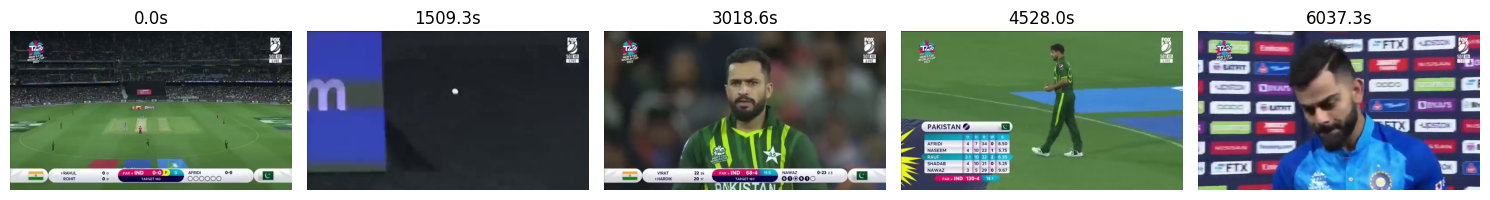

In [9]:
# Set the path to your cricket match video
video_path = CONFIG["input_video"]

# Check if the file exists before proceeding
if not os.path.exists(video_path):
    print(f"Please update the CONFIG['input_video'] with the path to your cricket match video.")
    # For demonstration, you can use a sample video URL
    print("For demonstration, you can download a sample cricket video or use a URL.")
else:
    # Display video information
    display_video_info(video_path)
    
    # Display sample frames
    display_frame_samples(video_path, num_samples=5)

In [10]:
def process_video_segment(video_path, start_time, duration, sample_rate=1):
    """Process a segment of the video and extract frames and audio.
    
    Args:
        video_path: Path to the video file
        start_time: Start time in seconds
        duration: Duration to extract in seconds
        sample_rate: Process every Nth frame
        
    Returns:
        Tuples (frames, audio_data, sample_rate)
    """
    # Initialize video processor
    processor = VideoProcessor(video_path)
    
    # Extract frames
    print(f"Extracting frames from {start_time}s to {start_time + duration}s...")
    start_time_process = time.time()
    frames = processor.extract_frames(start_time, duration, sample_rate)
    end_time_process = time.time()
    print(f"Extracted {len(frames)} frames in {end_time_process - start_time_process:.2f} seconds")
    
    # Extract audio if available
    audio_data, audio_rate = processor.extract_audio(start_time, duration)
    if audio_data is not None:
        print(f"Extracted audio: {audio_data.shape} samples at {audio_rate}Hz")
    
    # Display a few frames
    if frames and CONFIG["show_frames"]:
        # Select a few frames to display
        display_frames = frames[::len(frames)//5] if len(frames) > 5 else frames
        
        fig, axes = plt.subplots(1, len(display_frames), figsize=(15, 3))
        if len(display_frames) == 1:
            axes = [axes]  # Make axes always iterable
            
        for i, (timestamp, frame) in enumerate(display_frames):
            # Convert BGR to RGB for display
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f"{timestamp:.1f}s")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Close the processor
    processor.close()
    
    return frames, audio_data, audio_rate

In [11]:
# Example usage - requires a valid video path in CONFIG
if os.path.exists(CONFIG["input_video"]):
    # Process a 10-second segment starting at 30 seconds into the video
    frames, audio_data, audio_rate = process_video_segment(
        CONFIG["input_video"], start_time=30, duration=10, sample_rate=5)
    
    # Save the extracted frames if desired
    # processor.save_frames(frames)

Opened video: C:\Users\vedha\Downloads\highlights.mp4
Video stream: <av.VideoStream #0 h264, yuv420p 640x360 at 0x286902508b0>
Audio stream: <av.AudioStream #1 aac at 44100Hz, stereo, fltp at 0x286902506d0>
Extracting frames from 30s to 40s...
Extracted 0 frames in 0.01 seconds


## Next Steps

Now that we have implemented the Video Ingestion & Decoding part of our Cricket Highlights Generator pipeline, we're ready to move on to the next stages:

1. ✅ Video Ingestion & Decoding (current stage)
2. Shot-Boundary & Scene Segmentation
   - Detect natural transitions in the video to divide it into meaningful segments
3. Feature Extraction (Visual, Audio, Text)
   - Analyze each segment for excitement indicators
4. Event Detection & Classification
   - Identify key cricket events (boundaries, wickets, etc.)

Our implementation provides a solid foundation with:
- Flexible video frame extraction with PyAV or Decord
- Audio extraction capabilities
- Configurable processing parameters
- Visualization tools for debugging

In the next notebook, we'll implement shot boundary detection to segment the cricket match into coherent scenes for further analysis.